# Predicting Future Energy Pricing 

In this notebook, we'll train a regression model on the task of predicting the next hour's electricity price. We will use past values of the electricity price as well as other features related to energy generation. 

# Imports

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

import tensorflow as tf

import xgboost as xgb


%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv
/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv


In [3]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

This dataset contains hourly information about the electricity generation in Spain for the period 2015-2019 (4 years). 


In [4]:
# Read the dataset

df = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv', parse_dates=['time'])

# EDA

In [5]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [6]:
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

We'll begin by dropping:
- Zeroes and NaNs: Columns filled with only zeroes or NaNs don't give us useful information, so we're getting rid of them.
- Unused Columns: We're removing columns with day-ahead forecasts because as we're focusing on understanding current energy patterns.


In [7]:
df = df.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead', 'price day ahead'], 
                            axis=1)

We'll take the 'time' column in the DataFrame and convert it into a proper datetime format. This is important because time series analysis depends on understanding the sequence of time. 

In [8]:
df['time'] = pd.to_datetime(df['time'], utc=True, infer_datetime_format=True)
df = df.set_index('time')

Missing data can cause problems in calculations and modeling. Let's check the DataFrame for NaN values.

In [9]:
print('Total missing values: {}'.format(df.isnull().values.sum()))

Total missing values: 292


Duplicate rows can artificially inflate the importance of certain data points. We'll find rows that are entirely identical and remove them. 

In [10]:
duplicates = df.duplicated(keep='first').sum()

print('Total duplicate rows: {}'.format(duplicates))

Total duplicate rows: 0


There are no duplicate values. However, there are some missing values (NaNs) in our dataset. Since we're working with time series data, where each point depends on the ones before it, we can't just delete these rows. Instead, a better solution would be to use interpolation to fill in the missing values.

In [11]:
df.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price actual                                    0
dtype: int64

The 'total load actual' column has the most missing values, so let's figure out how to handle them. 

We'll use interpolation to fill in the missing values. Interpolation preserves the order and trend of your time series data, which is essential for understanding patterns and making predictions. Unlike simply deleting rows with missing values, interpolation lets you keep all your data points, potentially improving your analysis.

In [12]:
df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
df.interpolate(method='linear', limit_direction='backward', inplace=True, axis=0)

# Visualization

In [13]:
def plot_target_seasonality(df, target_column, freq='M', figsize=(10, 6)):
    """Plots the target variable to visualize potential seasonality.

    Args:
        df (pandas.DataFrame): The DataFrame containing the target variable.
        target_column (str): The name of the column containing the target variable.
        freq (str, optional): Resampling frequency for time series decomposition 
                             ('M' for monthly, 'W' for weekly, etc.). Defaults to 'M'.
        figsize (tuple, optional): Size of the figure. Defaults to (10, 6).
    """

    # Check if the target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")

    # Resample the target variable based on the provided frequency
    resampled_target = df[target_column].asfreq('M')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(resampled_target)

    # Customize the plot
    ax.set_title(f"Seasonality in Target Variable ({target_column})")
    ax.set_xlabel("Time")
    ax.set_ylabel(target_column)
    ax.grid(True)
    plt.show()


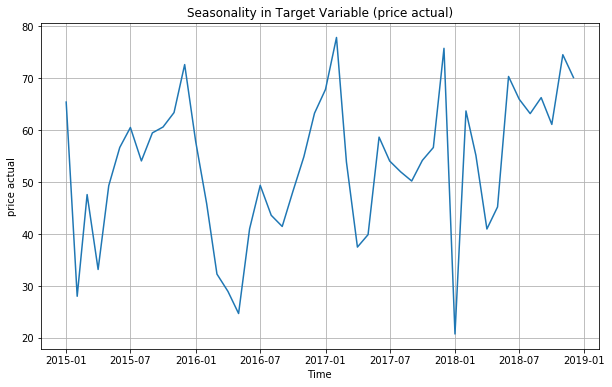

In [14]:
plot_target_seasonality(df, target_column='price actual') 

The plot clearly shows repeating patterns every month. The spikes in the data consistently happen during the same months each year. This strong seasonality suggests that creating a feature to represent the month could be very useful for our model.

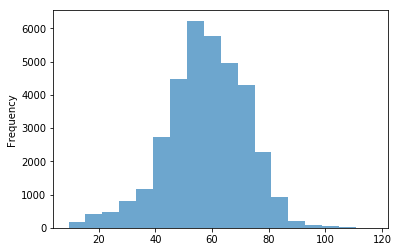

In [15]:
df['price actual'].plot.hist(bins=18, alpha=0.65)

From the figure, the energy price seems to follow a roughly normal distribution, suggesting standardization might be helpful. However, let's verify if there are any other necessary transformations by examining the decomposed time series for stationarity.

## Decomposition and stationarity tests

We'll perform the Augmented Dickey-Fuller test on our target column and examine the plots to identify trends, seasonal patterns, and any irregularities.

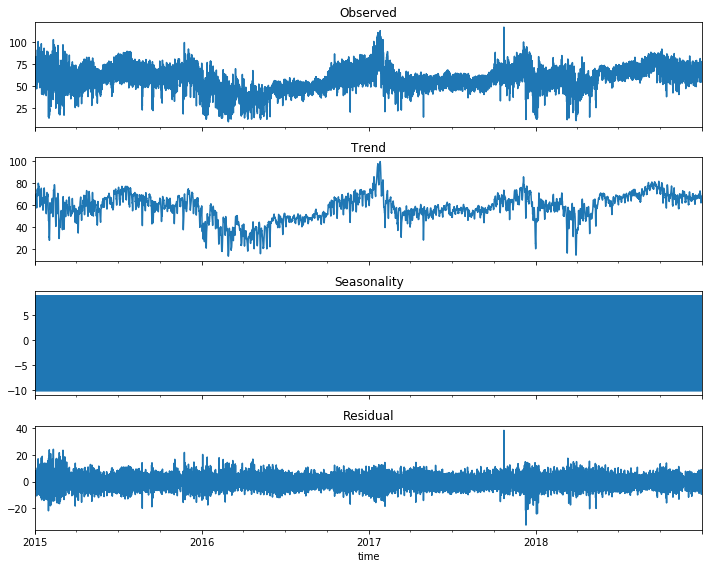

ADF Statistic: -9.147016232851177
p-value: 2.7504934849344875e-15
Critical Values:
	 1% : -3.4305367814665044
	 5% : -2.8616225527935106
	 10% : -2.566813940257257


In [16]:
def decompose_and_test_stationarity(df, target_column='price actual'):
    """ Decomposes a time series into trend, seasonality, and residual components,
        and performs the Augmented Dickey-Fuller (ADF) test for stationarity.

    Args:
        df (pandas.DataFrame): DataFrame containing the target variable as a column.
        target_column (str, optional): Name of the column containing the target variable. 
                                       Defaults to 'price actual'.
    """

    # Decomposition
    decomposition = sm.tsa.seasonal_decompose(df[target_column], model='additive')  # Adjust 'model' to 'multiplicative' if needed

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
    decomposition.observed.plot(ax=axes[0], legend=False, title="Observed")
    decomposition.trend.plot(ax=axes[1], legend=False, title="Trend")
    decomposition.seasonal.plot(ax=axes[2], legend=False, title="Seasonality")
    decomposition.resid.plot(ax=axes[3], legend=False, title="Residual")
    plt.tight_layout()
    plt.show()

    # Stationarity Test (Augmented Dickey-Fuller)
    adf_result = adfuller(df[target_column])
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t', key, ':', value)

# Call   
decompose_and_test_stationarity(df) 

A stationary time series has statistical properties (mean, variance, etc.) that remain constant over time. This is important for many modeling techniques.

Null Hypothesis: The ADF test assumes the time series is not stationary (i.e., has a unit root).
Goal: To reject the null hypothesis, which would provide evidence of stationarity.

Interpreting Our Results

ADF Statistic: -9.147 is very negative. This suggests potential stationarity.
p-value: 2.750...e-15 is extremely small (much less than common significance levels like 0.05 or 0.01). This strongly supports rejecting the null hypothesis.
Critical Values: The ADF statistic is more negative than all the critical values. This further confirms a rejection of the null hypothesis.
Conclusion

Based on our results, there's strong evidence that the energy price time series is stationary. 


## Correlation

In [17]:
correlations = df.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
generation waste                               0.168710
generation biomass                             0.142671
generation other                               0.099914
generation solar                               0.098529
generation hydro water reservoir               0.071910
generation nuclear                            -0.053016
generation hydro run-of-river and poundage    -0.136659
generation wind onshore                       -0.220497
generation hydro pumped storage consumption   -0.426196


Our analysis already reveals fascinating relationships between energy price and other features.  As expected, total load and fossil fuel generation show a positive correlation with price.  Interestingly, wind speed and energy storage consumption through hydroelectric pumping have a negative correlation with price.

In [18]:
df = df.drop(columns = ['generation waste', 'generation biomass', 'generation other', 'generation solar', 
                        'generation hydro water reservoir', 'generation nuclear', 
                        'generation hydro run-of-river and poundage'])

# Feature Engineering

We'll generate the following features:
- Hour: Energy demand and prices often fluctuate throughout the day (e.g., peaks during business hours, lower at night). This feature captures those patterns.
- Weekday: Energy usage might differ between weekdays and weekends due to variations in industrial and commercial activity.
- Month: Seasonality plays a major role in energy markets (e.g., heating in winter, air conditioning in summer). The month feature helps the model learn these recurring trends.The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [19]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month

The 'business hour' feature distinguishes between periods of high commercial activity, a midday break, and off-hours. This pattern likely influences energy demand and prices.

In [20]:
def generate_business_hour_feature(df):
    """
    Generate 'business hour' feature based on the index hour of the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the index with datetime values.

    Returns:
    DataFrame: The DataFrame with the 'business hour' feature added.
    """
    df['business hour'] = 0
    business_hours_mask = ((df.index.hour > 8) & (df.index.hour < 14)) | ((df.index.hour > 16) & (df.index.hour < 21))
    df.loc[business_hours_mask, 'business hour'] = 2
    df.loc[(df.index.hour >= 14) & (df.index.hour <= 16), 'business hour'] = 1
    return df

df = generate_business_hour_feature(df)

Energy consumption patterns often differ between weekdays, Saturdays, and Sundays due to variations in business and social activities. The 'weekend' feature allows the model to learn these distinctions.

In [21]:
def generate_weekend_feature(df):
    """
    Generate 'weekend' feature based on the day of the week of the DataFrame index.

    Parameters:
    df (DataFrame): The DataFrame containing the index with datetime values.

    Returns:
    DataFrame: The DataFrame with the 'weekend' feature added.
    """
    def determine_weekend(day_of_week):
        if day_of_week in (5, 6):  # Check for Saturday (5) and Sunday (6)
            return 2 if day_of_week == 6 else 1 
        else:
            return 0

    df['weekend'] = df.index.dayofweek.map(determine_weekend)
    return df

df = generate_weekend_feature(df)


# Modelling

In [22]:
target='price actual'

# Split data into feature matrix and target vector
X, y = df.drop(columns=target), df[target]

# split data into train / validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=42)

In [23]:
# Assign variables for baselines and calculate baselines
y_pred = [y_train.mean()]*len(y_train)
mean_baseline_pred = y_train.mean()
baseline_mae = mean_absolute_error(y_train,y_pred)
baseline_mse = mean_squared_error(y_train,y_pred)

# Print statement to show all baseline values
print('Mean Price Per KW/h Baseline Pred:', mean_baseline_pred)
print()
print('Baseline Mae:',baseline_mae)
print()
print('Baseline MSE:',baseline_mse)

Mean Price Per KW/h Baseline Pred: 57.89679726213009

Baseline Mae: 11.077446531082652

Baseline MSE: 201.41997417796264


In [24]:
from joblib import dump

def save_model(model, model_file):
    """
    Save the trained model to a file in joblib format.

    Parameters:
    model: The trained model object.
    model_file (str): Path to save the XGBoost model.
    """
    dump(model, model_file)

In [25]:
def train_xgboost_regressor(X_train, y_train, X_test, y_test, target):
    """
    Train an XGBoost regressor using cross-validation, tune hyperparameters, and evaluate the model.

    Parameters:
    df (DataFrame): The DataFrame containing the features and target variable.
    features (list): List of feature column names.
    target (str): Name of the target variable column.

    Returns:
    float: Root mean squared error (RMSE) of the model.
    float: R-squared (R2) score of the model.
    """

    # Define the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor()

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'learning_rate': [0.1],
        'max_depth': [5],
        #'min_child_weight': [1, 2, 3],
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Initialize XGBoost regressor with best parameters
    best_xgb_regressor = xgb.XGBRegressor(**best_params)

    # Perform cross-validation
    cv_scores = cross_val_score(best_xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Train the XGBoost regressor on the full training set
    best_xgb_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_xgb_regressor.predict(X_test)
    
    #dump(best_xgb_regressor, 'xgb_model.joblib')
    save_model(best_xgb_regressor, 'xgb_model.joblib')

    # Calculate RMSE and R2 score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2


mse, r2 = train_xgboost_regressor(X_train, y_train, X_test, y_test, target)
print("Test MSE:", mse)
print("Test R2 Score:", r2)

[19:58:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def train_random_forest_regressor(X_train, y_train, X_test, y_test):
    """
    Train a Random Forest regressor using cross-validation, tune hyperparameters, and evaluate the model.

    Parameters:
    X_train (DataFrame): The DataFrame containing the training features.
    y_train (Series): The Series containing the training target variable.
    X_test (DataFrame): The DataFrame containing the testing features.
    y_test (Series): The Series containing the testing target variable.

    Returns:
    float: Root mean squared error (RMSE) of the model.
    float: R-squared (R2) score of the model.
    """

    # Define the Random Forest regressor
    rf_regressor = RandomForestRegressor()

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Initialize Random Forest regressor with best parameters
    best_rf_regressor = RandomForestRegressor(**best_params)

    # Perform cross-validation
    cv_scores = cross_val_score(best_rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Train the Random Forest regressor on the full training set
    best_rf_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_rf_regressor.predict(X_test)
    
    save_model(best_rf_regressor, 'rf_model.joblib')

    # Calculate MSE and R2 score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

mse, r2 = train_random_forest_regressor(X_train, y_train, X_test, y_test)
print("Test MSE:", mse)
print("Test R2 Score:", r2)


In [33]:
# user_input = pd.DataFrame()

# user_input['generation fossil brown coal/lignite'] = 582.0 # 0 - 999
# user_input['generation fossil gas'] = 5537.0 # 0 - 20034
# user_input['generation fossil hard coal'] = 4039.0  # 0 - 8315
# user_input['generation fossil oil'] = 331.0 # 0 - 445
# user_input['generation hydro pumped storage consumption'] = 454.0 # 0 - 4532
# user_input['generation other renewable'] = 97.0 # 0 - 119
# user_input['generation wind onshore'] = 7556.0 # 0 - 17436
# user_input['total load actual'] = 31648.0 # 18041 - 41015
# user_input['hour'] = 11
# user_input['weekday'] = 0
# user_input['month'] = 10
# user_input['business hour'] = 2
# user_input['weekend'] = 0

In [26]:
from joblib import load

xgb = load('xgb_model.joblib')

[19:59:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
user_input = X_test.sample()

In [28]:
xgb.predict(user_input)

array([54.041737], dtype=float32)